# Pandas Dataframes
This notebook demonstrates how systematic analysis of tally scores is possible using Pandas dataframes. A dataframe can be automatically generated using the `Tally.get_pandas_dataframe(...)` method. Furthermore, by linking the tally data in a statepoint file with geometry and material information from a summary file, the dataframe can be shown with user-supplied labels.

In [1]:
import glob
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd
import openmc
%matplotlib inline

## Generate Input Files

First we need to define materials that will be used in the problem. We will create three materials for the fuel, water, and cladding of the fuel pin.

In [2]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide('U235', 3.7503e-4)
fuel.add_nuclide('U238', 2.2625e-2)
fuel.add_nuclide('O16', 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 4.9457e-2)
water.add_nuclide('O16', 2.4732e-2)
water.add_nuclide('B10', 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 7.2758e-3)

With our three materials, we can now create a materials file object that can be exported to an actual XML file.

In [3]:
# Instantiate a Materials collection
materials = openmc.Materials([fuel, water, zircaloy])

# Export to "materials.xml"
materials.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins for which we can use OpenMC's lattice/universe feature. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [4]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='vacuum')
min_y = openmc.YPlane(y0=-10.71, boundary_type='vacuum')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10.71, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10.71, boundary_type='reflective')

With the surfaces defined, we can now construct a fuel pin cell from cells that are defined by intersections of half-spaces created by the surfaces.

In [5]:
# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel', fill=fuel,
                        region=-fuel_outer_radius)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad', fill=zircaloy)
clad_cell.region = +fuel_outer_radius & -clad_outer_radius

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator', fill=water,
                             region=+clad_outer_radius)

# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin', cells=[
    fuel_cell, clad_cell, moderator_cell
])

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26 cm pitch.

In [6]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel - 0BA')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2
assembly.universes = [[pin_cell_universe] * 17] * 17

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [7]:
# Create root Cell
root_cell = openmc.Cell(name='root cell', fill=assembly)

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [8]:
# Create Geometry and export to "geometry.xml"
geometry = openmc.Geometry(root_universe)
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 5 inactive batches and 15 minimum active batches each with 2500 particles. We also tell OpenMC to turn tally triggers on, which means it will keep running until some criterion on the uncertainty of tallies is reached.

In [9]:
# OpenMC simulation parameters
min_batches = 20
max_batches = 200
inactive = 5
particles = 2500

# Instantiate a Settings object
settings = openmc.Settings()
settings.batches = min_batches
settings.inactive = inactive
settings.particles = particles
settings.output = {'tallies': False}
settings.trigger_active = True
settings.trigger_max_batches = max_batches

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.Source(space=uniform_dist)

# Export to "settings.xml"
settings.export_to_xml()

Let us also create a plot file that we can use to verify that our pin cell geometry was created successfully.

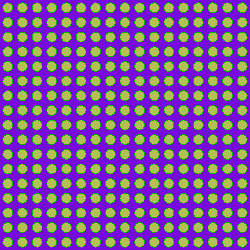

In [10]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.width = [21.5, 21.5]
plot.pixels = [250, 250]
plot.color_by = 'material'

# Show plot
openmc.plot_inline(plot)

As we can see from the plot, we have a nice array of pin cells with fuel, cladding, and water! Before we run our simulation, we need to tell the code what we want to tally. The following code shows how to create a variety of tallies.

In [11]:
# Instantiate an empty Tallies object
tallies = openmc.Tallies()

Instantiate a fission rate mesh Tally

In [12]:
# Instantiate a tally Mesh
mesh = openmc.RegularMesh(mesh_id=1)
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.width = [1.26, 1.26]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate energy Filter
energy_filter = openmc.EnergyFilter([0, 0.625, 20.0e6])

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter, energy_filter]
tally.scores = ['fission', 'nu-fission']

# Add mesh and Tally to Tallies
tallies.append(tally)

Instantiate a cell Tally with nuclides

In [13]:
# Instantiate tally Filter
cell_filter = openmc.CellFilter(fuel_cell)

# Instantiate the tally
tally = openmc.Tally(name='cell tally')
tally.filters = [cell_filter]
tally.scores = ['scatter']
tally.nuclides = ['U235', 'U238']

# Add mesh and tally to Tallies
tallies.append(tally)

Create a "distribcell" Tally. The distribcell filter allows us to tally multiple repeated instances of the same cell throughout the geometry.

In [14]:
# Instantiate tally Filter
distribcell_filter = openmc.DistribcellFilter(moderator_cell)

# Instantiate tally Trigger for kicks
trigger = openmc.Trigger(trigger_type='std_dev', threshold=5e-5)
trigger.scores = ['absorption']

# Instantiate the Tally
tally = openmc.Tally(name='distribcell tally')
tally.filters = [distribcell_filter]
tally.scores = ['absorption', 'scatter']
tally.triggers = [trigger]

# Add mesh and tally to Tallies
tallies.append(tally)

In [15]:
# Export to "tallies.xml"
tallies.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [16]:
# Remove old HDF5 (summary, statepoint) files
!rm statepoint.*

# Run OpenMC!
openmc.run()

zsh:1: no matches found: statepoint.*
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%


       42/1    0.68262    0.68790 +/- 0.00427
 Triggers unsatisfied, max unc./thresh. is 51.64336419771116 for absorption in
 tally 3
       43/1    0.70218    0.68828 +/- 0.00418
 Triggers unsatisfied, max unc./thresh. is 50.670570340468814 for absorption in
 tally 3
       44/1    0.67643    0.68797 +/- 0.00408
 Triggers unsatisfied, max unc./thresh. is 49.69199356343392 for absorption in
 tally 3
       45/1    0.67103    0.68755 +/- 0.00400
 Triggers unsatisfied, max unc./thresh. is 48.44632012698348 for absorption in
 tally 3
       46/1    0.65599    0.68678 +/- 0.00398
 Triggers unsatisfied, max unc./thresh. is 47.34469866924748 for absorption in
 tally 3
       47/1    0.64796    0.68586 +/- 0.00399
 Triggers unsatisfied, max unc./thresh. is 46.49104551849076 for absorption in
 tally 3
       48/1    0.69638    0.68610 +/- 0.00390
 Triggers unsatisfied, max unc./thresh. is 45.709058495601944 for absorption in
 tally 3
       49/1    0.69484    0.68630 +/- 0.00382
 Triggers unsa

       81/1    0.65907    0.68705 +/- 0.00270
 Triggers unsatisfied, max unc./thresh. is 30.770354748329673 for absorption in
 tally 3
       82/1    0.63285    0.68635 +/- 0.00276
 Triggers unsatisfied, max unc./thresh. is 30.494055493974837 for absorption in
 tally 3
       83/1    0.65128    0.68590 +/- 0.00276
 Triggers unsatisfied, max unc./thresh. is 30.31368198832468 for absorption in
 tally 3
       84/1    0.65957    0.68556 +/- 0.00274
 Triggers unsatisfied, max unc./thresh. is 29.927509740512043 for absorption in
 tally 3
       85/1    0.69936    0.68574 +/- 0.00271
 Triggers unsatisfied, max unc./thresh. is 29.684480624889716 for absorption in
 tally 3
       86/1    0.71538    0.68610 +/- 0.00270
 Triggers unsatisfied, max unc./thresh. is 30.42821373418053 for absorption in
 tally 3
       87/1    0.67737    0.68600 +/- 0.00267
 Triggers unsatisfied, max unc./thresh. is 30.08396896848712 for absorption in
 tally 3
       88/1    0.67516    0.68587 +/- 0.00264
 Triggers un

      120/1    0.67682    0.68499 +/- 0.00219
 Triggers unsatisfied, max unc./thresh. is 25.600502408827925 for absorption in
 tally 3
      121/1    0.64612    0.68465 +/- 0.00220
 Triggers unsatisfied, max unc./thresh. is 25.442400998883397 for absorption in
 tally 3
      122/1    0.65743    0.68442 +/- 0.00219
 Triggers unsatisfied, max unc./thresh. is 25.314147051671682 for absorption in
 tally 3
      123/1    0.67460    0.68434 +/- 0.00217
 Triggers unsatisfied, max unc./thresh. is 25.120655024301723 for absorption in
 tally 3
      124/1    0.63622    0.68393 +/- 0.00219
 Triggers unsatisfied, max unc./thresh. is 25.173748425745888 for absorption in
 tally 3
      125/1    0.74014    0.68440 +/- 0.00222
 Triggers unsatisfied, max unc./thresh. is 24.969908358640748 for absorption in
 tally 3
      126/1    0.66532    0.68424 +/- 0.00221
 Triggers unsatisfied, max unc./thresh. is 24.763458789173267 for absorption in
 tally 3
      127/1    0.66151    0.68406 +/- 0.00220
 Triggers

      159/1    0.67616    0.68360 +/- 0.00185
 Triggers unsatisfied, max unc./thresh. is 21.48299566167353 for absorption in
 tally 3
      160/1    0.67492    0.68355 +/- 0.00184
 Triggers unsatisfied, max unc./thresh. is 21.352926864543797 for absorption in
 tally 3
      161/1    0.69218    0.68360 +/- 0.00183
 Triggers unsatisfied, max unc./thresh. is 21.3145021538723 for absorption in
 tally 3
      162/1    0.66037    0.68345 +/- 0.00183
 Triggers unsatisfied, max unc./thresh. is 21.1820405677372 for absorption in
 tally 3
      163/1    0.65640    0.68328 +/- 0.00182
 Triggers unsatisfied, max unc./thresh. is 21.086966040066464 for absorption in
 tally 3
      164/1    0.65113    0.68308 +/- 0.00182
 Triggers unsatisfied, max unc./thresh. is 20.95392716842 for absorption in
 tally 3
      165/1    0.70691    0.68323 +/- 0.00182
 Triggers unsatisfied, max unc./thresh. is 20.837836560668773 for absorption in
 tally 3
      166/1    0.67295    0.68317 +/- 0.00181
 Triggers unsatisf

      198/1    0.66675    0.68196 +/- 0.00161
 Triggers unsatisfied, max unc./thresh. is 19.51191007087699 for absorption in
 tally 3
      199/1    0.64492    0.68177 +/- 0.00161
 Triggers unsatisfied, max unc./thresh. is 19.511121460032857 for absorption in
 tally 3
      200/1    0.69441    0.68184 +/- 0.00160
 Triggers unsatisfied, max unc./thresh. is 19.41826259948151 for absorption in
 tally 3
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 3.2763e-01 seconds
   Reading cross sections          = 3.1447e-01 seconds
 Total time in simulation          = 2.3755e+01 seconds
   Time in transport only          = 2.3701e+01 seconds
   Time in inactive batches        = 4.2962e-01 seconds
   Time in active batches          = 2.3325e+01 seconds
   Time synchronizing fission bank = 2.0652e-02 seconds
     Sampling source sites         = 1.7317e-02 seconds
     SEND/RECV source sites

## Tally Data Processing

In [17]:
# We do not know how many batches were needed to satisfy the 
# tally trigger(s), so find the statepoint file(s)
statepoints = glob.glob('statepoint.*.h5')

# Load the last statepoint file
sp = openmc.StatePoint(statepoints[-1])

**Analyze the mesh fission rate tally**

In [18]:
# Find the mesh tally with the StatePoint API
tally = sp.get_tally(name='mesh tally')

# Print a little info about the mesh tally to the screen
print(tally)

Tally
	ID             =	1
	Name           =	mesh tally
	Filters        =	MeshFilter, EnergyFilter
	Nuclides       =	total
	Scores         =	['fission', 'nu-fission']
	Estimator      =	tracklength


Use the new Tally data retrieval API with pure NumPy

In [19]:
# Get the relative error for the thermal fission reaction 
# rates in the four corner pins 
data = tally.get_values(scores=['fission'],
                        filters=[openmc.MeshFilter, openmc.EnergyFilter], \
                        filter_bins=[((1,1),(1,17), (17,1), (17,17)), \
                                    ((0., 0.625),)], value='rel_err')
print(data)

[[[0.04969994]]

 [[0.02200773]]

 [[0.12289506]]

 [[0.05303359]]]


In [20]:
# Get a pandas dataframe for the mesh tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Set the Pandas float display settings
pd.options.display.float_format = '{:.2e}'.format

# Print the first twenty rows in the dataframe
df.head(20)

mesh 1       energy low [eV] energy high [eV]       score     mean  \
        x  y  z                                                         
0       1  1  1        0.00e+00         6.25e-01     fission 2.10e-04   
1       1  1  1        0.00e+00         6.25e-01  nu-fission 5.11e-04   
2       1  1  1        6.25e-01         2.00e+07     fission 7.19e-05   
3       1  1  1        6.25e-01         2.00e+07  nu-fission 1.89e-04   
4       2  1  1        0.00e+00         6.25e-01     fission 2.19e-04   
5       2  1  1        0.00e+00         6.25e-01  nu-fission 5.33e-04   
6       2  1  1        6.25e-01         2.00e+07     fission 6.98e-05   
7       2  1  1        6.25e-01         2.00e+07  nu-fission 1.85e-04   
8       3  1  1        0.00e+00         6.25e-01     fission 2.23e-04   
9       3  1  1        0.00e+00         6.25e-01  nu-fission 5.44e-04   
10      3  1  1        6.25e-01         2.00e+07     fission 6.69e-05   
11      3  1  1        6.25e-01         2.00e+07  nu-fission 1.76e-04   
12      4  1  1        0.00e+00         6.25e-01     fission 2.09e-04   
13      4  1  1        0.00e+00         6.25e-01  nu-fission 5.09e-04   
14      4  1  1        6.25e-01         2.00e+07     fission 6.72e-05   
15      4  1  1        6.25e-01         2.00e+07  nu-fission 1.77e-04   
16      5  1  1        0.00e+00         6.25e-01     fission 2.11e-04   
17      5  1  1        0.00e+00         6.25e-01  nu-fission 5.15e-04   
18      5  1  1        6.25e-01         2.00e+07     fission 6.47e-05   
19      5  1  1        6.25e-01         2.00e+07  nu-fission 1.70e-04   

   std. dev.  
              
0   1.04e-05  
1   2.54e-05  
2   1.83e-06  
3   4.75e-06  
4   9.36e-06  
5   2.28e-05  
6   1.63e-06  
7   4.24e-06  
8   1.02e-05  
9   2.48e-05  
10  1.65e-06  
11  4.27e-06  
12  9.24e-06  
13  2.25e-05  
14  1.65e-06  
15  4.32e-06  
16  8.34e-06  
17  2.03e-05  
18  1.40e-06  
19  3.66e-06

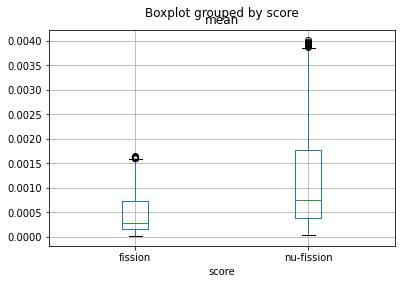

In [21]:
# Create a boxplot to view the distribution of
# fission and nu-fission rates in the pins
bp = df.boxplot(column='mean', by='score')

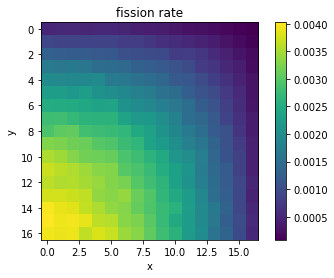

In [22]:
# Extract thermal nu-fission rates from pandas
fiss = df[df['score'] == 'nu-fission']
fiss = fiss[fiss['energy low [eV]'] == 0.0]

# Extract mean and reshape as 2D NumPy arrays
mean = fiss['mean'].values.reshape((17,17))

plt.imshow(mean, interpolation='nearest')
plt.title('fission rate')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

**Analyze the cell+nuclides scatter-y2 rate tally**

In [23]:
# Find the cell Tally with the StatePoint API
tally = sp.get_tally(name='cell tally')

# Print a little info about the cell tally to the screen
print(tally)

Tally
	ID             =	2
	Name           =	cell tally
	Filters        =	CellFilter
	Nuclides       =	U235 U238
	Scores         =	['scatter']
	Estimator      =	tracklength


In [24]:
# Get a pandas dataframe for the cell tally data
df = tally.get_pandas_dataframe()

# Print the first twenty rows in the dataframe
df.head(20)

,cell,nuclide,score,mean,std. dev.
0,1,U235,scatter,3.82e-02,4.48e-05
1,1,U238,scatter,2.34e+00,2.52e-03


Use the new Tally data retrieval API with pure NumPy

In [25]:
# Get the standard deviations the total scattering rate
data = tally.get_values(scores=['scatter'], 
                        nuclides=['U238', 'U235'], value='std_dev')
print(data)

[[[2.52057084e-03]
  [4.48210552e-05]]]


**Analyze the distribcell tally**

In [26]:
# Find the distribcell Tally with the StatePoint API
tally = sp.get_tally(name='distribcell tally')

# Print a little info about the distribcell tally to the screen
print(tally)

Tally
	ID             =	3
	Name           =	distribcell tally
	Filters        =	DistribcellFilter
	Nuclides       =	total
	Scores         =	['absorption', 'scatter']
	Estimator      =	tracklength


Use the new Tally data retrieval API with pure NumPy

In [27]:
# Get the relative error for the scattering reaction rates in
# the first 10 distribcell instances 
data = tally.get_values(scores=['scatter'], filters=[openmc.DistribcellFilter],
                        filter_bins=[tuple(range(10))], value='rel_err')
print(data)

[[[0.01301475]]

 [[0.0136507 ]]

 [[0.01260538]]

 [[0.01293374]]

 [[0.01219012]]

 [[0.01191931]]

 [[0.0127884 ]]

 [[0.01339325]]

 [[0.01309524]]

 [[0.0133674 ]]]


Now that we're done getting data from the statepoint file, we'll close it to free the file handle for subsequent OpenMC runs.

In [28]:
# Close the statepoint file now that we're done gathering info from it
sp.close()

Print the distribcell tally dataframe

In [29]:
# Get a pandas dataframe for the distribcell tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Print the last twenty rows in the dataframe
df.tail(20)

level 1      level 2         level 3      distribcell       score  \
       univ cell     lat            univ cell                           
         id   id      id   x   y      id   id                           
558       3    4       2   7  16       1    3         279  absorption   
559       3    4       2   7  16       1    3         279     scatter   
560       3    4       2   8  16       1    3         280  absorption   
561       3    4       2   8  16       1    3         280     scatter   
562       3    4       2   9  16       1    3         281  absorption   
563       3    4       2   9  16       1    3         281     scatter   
564       3    4       2  10  16       1    3         282  absorption   
565       3    4       2  10  16       1    3         282     scatter   
566       3    4       2  11  16       1    3         283  absorption   
567       3    4       2  11  16       1    3         283     scatter   
568       3    4       2  12  16       1    3         284  absorption   
569       3    4       2  12  16       1    3         284     scatter   
570       3    4       2  13  16       1    3         285  absorption   
571       3    4       2  13  16       1    3         285     scatter   
572       3    4       2  14  16       1    3         286  absorption   
573       3    4       2  14  16       1    3         286     scatter   
574       3    4       2  15  16       1    3         287  absorption   
575       3    4       2  15  16       1    3         287     scatter   
576       3    4       2  16  16       1    3         288  absorption   
577       3    4       2  16  16       1    3         288     scatter   

        mean std. dev.  
                        
                        
558 7.23e-04  1.05e-05  
559 9.08e-02  6.39e-04  
560 6.75e-04  1.09e-05  
561 8.49e-02  6.75e-04  
562 6.22e-04  1.06e-05  
563 7.85e-02  6.36e-04  
564 5.66e-04  1.01e-05  
565 7.17e-02  5.80e-04  
566 4.94e-04  9.18e-06  
567 6.35e-02  5.45e-04  
568 4.34e-04  8.41e-06  
569 5.54e-02  5.15e-04  
570 3.58e-04  7.60e-06  
571 4.70e-02  4.81e-04  
572 2.83e-04  7.08e-06  
573 3.84e-02  4.47e-04  
574 2.19e-04  6.36e-06  
575 2.99e-02  3.89e-04  
576 1.18e-04  4.29e-06  
577 1.85e-02  2.75e-04

In [30]:
# Show summary statistics for absorption distribcell tally data
absorption = df[df['score'] == 'absorption']
absorption[['mean', 'std. dev.']].dropna().describe()

# Note that the maximum standard deviation does indeed
# meet the 5e-5 threshold set by the tally trigger

,mean,std. dev.
,,
,,
count,2.89e+02,2.89e+02
mean,4.19e-04,6.85e-06
std,2.43e-04,2.55e-06
min,1.65e-05,1.25e-06
25%,2.08e-04,4.81e-06
50%,3.95e-04,6.87e-06
75%,6.19e-04,8.77e-06
max,9.04e-04,1.51e-05


Perform a statistical test comparing the tally sample distributions for two categories of fuel pins.

In [31]:
# Extract tally data from pins in the pins divided along y=-x diagonal 
multi_index = ('level 2', 'lat',)
lower = df[df[multi_index + ('x',)] + df[multi_index + ('y',)] < 16]
upper = df[df[multi_index + ('x',)] + df[multi_index + ('y',)] > 16]
lower = lower[lower['score'] == 'absorption']
upper = upper[upper['score'] == 'absorption']

# Perform non-parametric Mann-Whitney U Test to see if the 
# absorption rates (may) come from same sampling distribution
u, p = scipy.stats.mannwhitneyu(lower['mean'], upper['mean'])
print('Mann-Whitney Test p-value: {0}'.format(p))

Mann-Whitney Test p-value: 0.4886239022425303


Note that the symmetry implied by the y=-x diagonal ensures that the two sampling distributions are identical. Indeed, as illustrated by the test above, for any reasonable significance level (*e.g.*, $\alpha$=0.05) one would **not reject** the null hypothesis that the two sampling distributions are identical.

Next, perform the same test but with two groupings of pins which are not symmetrically identical to one another.

In [32]:
# Extract tally data from pins in the pins divided along y=x diagonal
multi_index = ('level 2', 'lat',)
lower = df[df[multi_index + ('x',)] > df[multi_index + ('y',)]]
upper = df[df[multi_index + ('x',)] < df[multi_index + ('y',)]]
lower = lower[lower['score'] == 'absorption']
upper = upper[upper['score'] == 'absorption']

# Perform non-parametric Mann-Whitney U Test to see if the 
# absorption rates (may) come from same sampling distribution
u, p = scipy.stats.mannwhitneyu(lower['mean'], upper['mean'])
print('Mann-Whitney Test p-value: {0}'.format(p))

Mann-Whitney Test p-value: 3.2855436374070945e-42


Note that the asymmetry implied by the y=x diagonal ensures that the two sampling distributions are *not* identical. Indeed, as illustrated by the test above, for any reasonable significance level (*e.g.*, $\alpha$=0.05) one would **reject** the null hypothesis that the two sampling distributions are identical.

/home/shriwise/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:title={'center':'Scattering Rates'}, xlabel='mean', ylabel='rel. err.'>

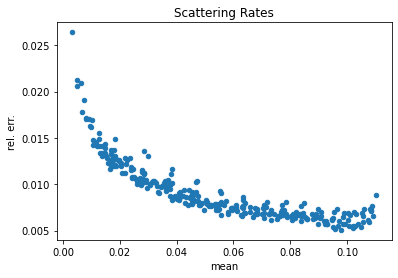

In [33]:
# Extract the scatter tally data from pandas
scatter = df[df['score'] == 'scatter']

scatter['rel. err.'] = scatter['std. dev.'] / scatter['mean']

# Show a scatter plot of the mean vs. the std. dev.
scatter.plot(kind='scatter', x='mean', y='rel. err.', title='Scattering Rates')

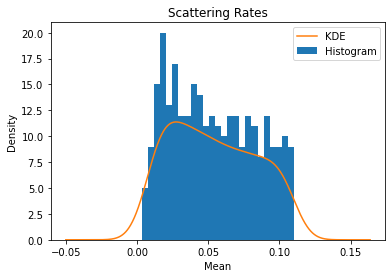

In [34]:
# Plot a histogram and kernel density estimate for the scattering rates
scatter['mean'].plot(kind='hist', bins=25)
scatter['mean'].plot(kind='kde')
plt.title('Scattering Rates')
plt.xlabel('Mean')
plt.legend(['KDE', 'Histogram'])